In [499]:
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower')
import numpy as np
from onset_detection import detected_samples
import matplotlib.pyplot as plt
import helper
import scipy.io.wavfile as wav
from datetime import datetime
import least_squares

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece



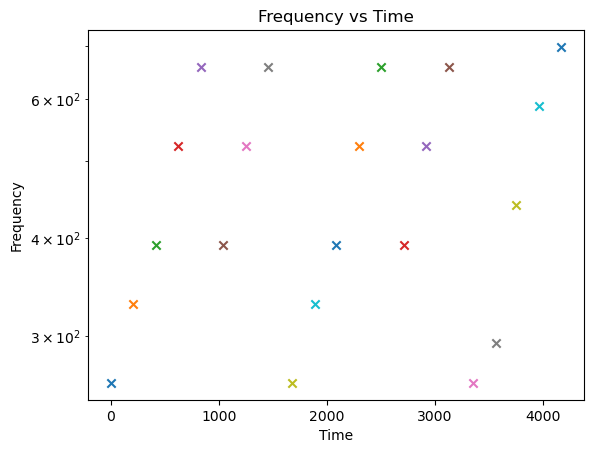

541


In [500]:
notes = process_midi_to_note_info(
    '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Prelude1.midi')
chords = notes_to_chords(notes, sustain=False)

plot_piece(chords, 20)
plt.show()
score = dict_to_frequency_list(chords)
print(len(score))


In [510]:
hop = 5000
sample_len = 1000
cov_dict = {}


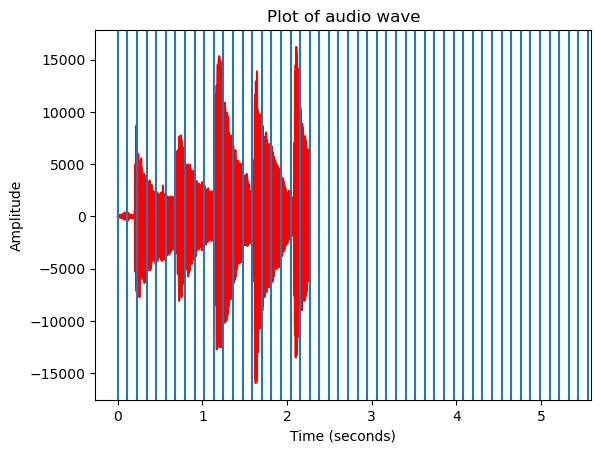

In [511]:
path =     '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_3.wav'
sample_rate, data = wav.read(path)

audio_duration = len(data)/sample_rate


time_samples = np.linspace(0, audio_duration, len(data))
sample_indices = np.arange(0, len(data), hop)
sample_data = [data[index:index+sample_len] for index in sample_indices]
helper.plot_audio(time_samples[:100000], data[:100000])
for i in sample_indices[:50]:
    plt.axvline(i/sample_rate)

In [513]:
def oltw(sample_data: list, score: list, time_samples: np.ndarray, n: int, pedal: bool = False, cov_dict:dict=None,back_track: int=0):
    state_number, audio_frame_number = 0, 0
    path = []
    for sample in sample_data[:-n]:
        ml = 0
        if np.sum(abs(sample))>10:
            lml = []
            num_lookahead = min(len(score) - state_number + 1, n) + back_track
            print(state_number, audio_frame_number)
            score_states = []
            for i in range(num_lookahead):
                score_states.append(max(state_number+i-back_track, 0))
                lml.append(-helper.stable_nlml(time_samples=time_samples, Y=sample, T=0.465, v=2.37, M=9,sigma_f=0.1, cov_dict=cov_dict, normalised=False,f=score[max(state_number+i-back_track, 0)]))
            print(score_states)
            print(lml)

            
            # priors = 1/np.arange(1, num_lookahead+1)
            priors = [0.98,0.99,1,0.99,0.98,0.97]#np.ones(num_lookahead)
            lml =np.array(lml)
            normalised_lml = lml/np.sum(abs(lml)) # Normalise to 1 so that we can feasibly compute the ml (e^lml)
            posterior_ml = np.exp(normalised_lml) * priors

            index = np.argmax(posterior_ml)
            ml = posterior_ml[index]

            state_number += index - back_track
        
        else:
            print("skipped the audio")
            
        path.append((state_number, audio_frame_number, ml))
        audio_frame_number += 1
        
    return path


In [514]:
sample_time_samples = np.linspace(0, sample_len/sample_rate, len(sample_data[0]))

for state in score[:250]:
    if str(state) not in cov_dict:
        cov_dict[str(state)] = helper.SM_kernel(
            sample_time_samples, sample_time_samples, M=9,  f=state, sigma_f=0.1, T=0.465, v=2.37) + 0.01**2 * np.eye(sample_len)

# path = oltw(sample_data[:30], score, sample_time_samples, 3)

In [520]:
path = oltw(sample_data[:80], score, sample_time_samples, n=4, cov_dict=cov_dict, back_track=2)

0 0
[0, 0, 0, 1, 2, 3]
[-6764414779.419428, -6764414779.419428, -6764414779.419428, -6848254814.662904, -6679609585.543753, -6984394041.969288]
0 1
[0, 0, 0, 1, 2, 3]
[-151451196155.89084, -151451196155.89084, -151451196155.89084, -151547342816.15747, -152405778114.24637, -154679869863.2861]
0 2
[0, 0, 0, 1, 2, 3]
[-3995619808815.2246, -3995619808815.2246, -3995619808815.2246, -24789994657646.59, -17715137990438.53, -15886079865794.73]
0 3
[0, 0, 0, 1, 2, 3]
[-199155881199.89294, -199155881199.89294, -199155881199.89294, -20707304012121.723, -14582017836754.156, -16059751815730.064]
0 4
[0, 0, 0, 1, 2, 3]
[-118330139140.79984, -118330139140.79984, -118330139140.79984, -13605100002413.291, -9529900499128.145, -9377331891911.828]
0 5
[0, 0, 0, 1, 2, 3]
[-279478532596.2632, -279478532596.2632, -279478532596.2632, -10498626312614.629, -7995026513594.678, -7086955978738.949]
0 6
[0, 0, 0, 1, 2, 3]
[-4129760454178.817, -4129760454178.817, -4129760454178.817, -8041963276918.796, -690940668984

In [516]:
print(-helper.stable_nlml(time_samples=sample_time_samples, Y=sample_data[8], T=0.465, v=2.37, M=9,sigma_f=0.1, cov_dict=cov_dict, normalised=False,f=score[3]))
print(-helper.stable_nlml(time_samples=sample_time_samples, Y=sample_data[8], T=0.465, v=2.37, M=9,sigma_f=0.1, cov_dict=cov_dict, normalised=False,f=score[0]))

-24132447244178.117
-22134603045693.598


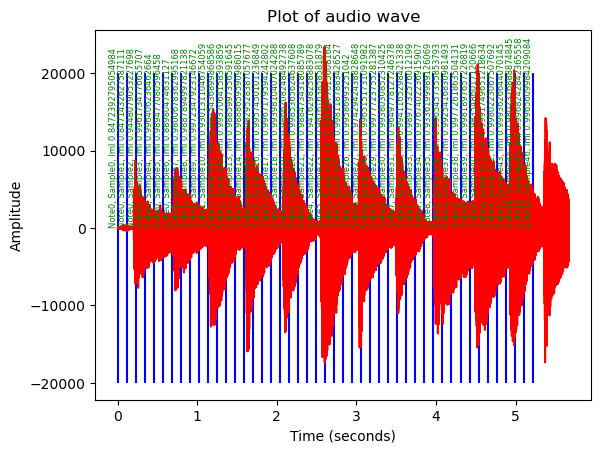

In [522]:
link =     '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_3.wav'
sample_rate, data = wav.read(link)
data=data[:250000]
audio_duration = len(data)/sample_rate
time_samples = np.linspace(0, audio_duration, len(data))
helper.plot_audio(time_samples, data)

for i in range(len(sample_indices[:47])):
    plt.vlines(sample_indices[i]/sample_rate, ymin=-
                       20000, ymax=20000, colors='blue', zorder=2)
    note = path[i][0]
    sample = path[i][1]
    lml = path[i][2]
    plt.text(sample_indices[i]/sample_rate, 0.3, f'Note{note}, Sample{sample}, lml {lml}', color='green', ha='right', va='bottom', rotation=90, fontsize=6)
    

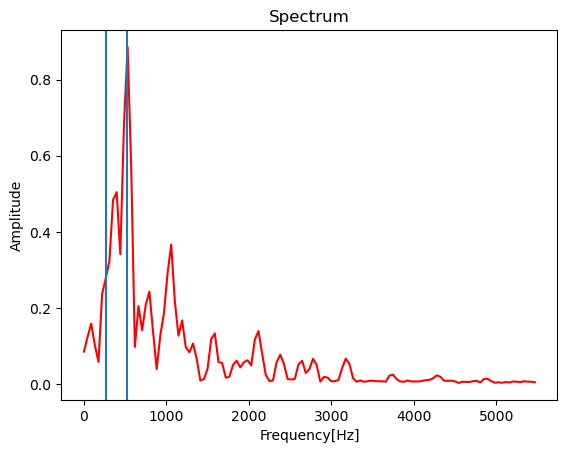

In [408]:
helper.plot_fft(sample_data[8], power_spectrum=True)
plt.axvline(262)
plt.axvline(522)

In [232]:
a = (-helper.stable_nlml(sample_time_samples, sample_data[7],normalised=False, f=score[2]))
b = (-helper.stable_nlml(sample_time_samples, sample_data[7],normalised=False, f=score[5]))
print(score[2],score[5])
probs = [a,b]
print(probs)
index = np.argmax(probs)
print(index)
print(probs[0])

[392] [392]
[-292437133059.6073, -292437133059.6073]
0
-292437133059.6073


In [109]:
print(-helper.stable_nlml(sample_time_samples, sample_data[13], f=[523]))
print(-helper.stable_nlml(sample_time_samples, sample_data[13], f=[523*2]))
print(-helper.stable_nlml(sample_time_samples, sample_data[13], f=[523/2]))

3259.4427636762825
3252.2297267161425
3263.6486692849944


In [113]:
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[262]))
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[262*2]))
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[262/2]))

3263.629826851649
3252.8785963126425
3285.4032855953687


In [112]:
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[523]))
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[523*2]))
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[523/2]))
print(-helper.stable_nlml(sample_time_samples, sample_data[3], f=[523/4]))

3252.885091032817
3251.659525636543
3263.6507569273112
3285.5472934197237


15.286218989498593


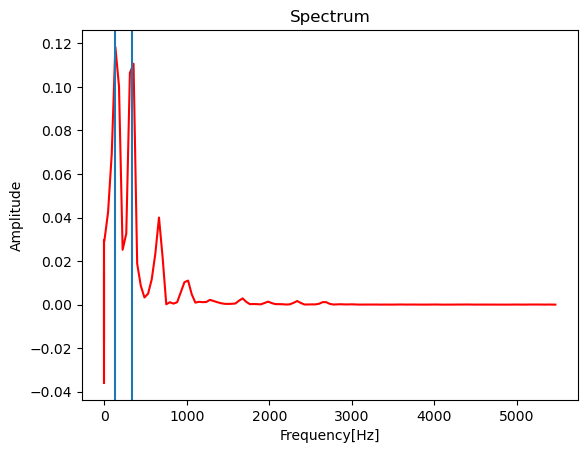

In [100]:
helper.plot_audio(sample_time_samples, sample_data[2])
helper.plot_fft(sample_data[2])
plt.axvline(261/2)
plt.axvline(330)
print(np.sum(abs(sample_data[3])))

In [91]:
print((-helper.relative_nlml(sample_time_samples, sample_data[2],M=15,sigma_f=5,  f=[261], T=0.465, v=2.37 )))
print((-helper.relative_nlml(sample_time_samples, sample_data[2],M=15, sigma_f=5, f=[330], T=0.465, v=2.37 )))

1it [00:00,  7.12it/s]
1it [00:00,  9.50it/s]

-3.658139087882506
-2.4897286877838316
